In [1]:
#Installing dependencies
!pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn


In [9]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Upload dataset(as zip file)
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv.zip to creditcard.csv.zip


In [6]:
# Unzip the Zipfile
import zipfile
import os

# Replace with your actual ZIP file name
zip_file = "creditcard.csv.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("unzipped")  # Extract to a folder named 'unzipped'

# List extracted files
os.listdir("unzipped")


['creditcard.csv']

In [10]:
df = pd.read_csv("unzipped/creditcard.csv")


In [11]:
# Data overview
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


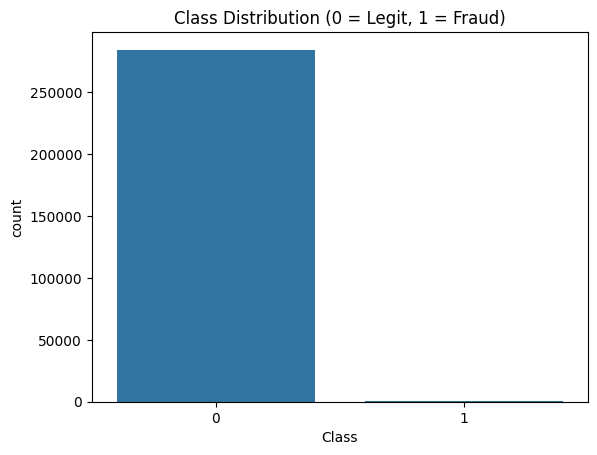

In [12]:
#Visualise Class Imbalance
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.show()


In [13]:
# Preprocessing : Scaling and Rearranging
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount', 'Class']] + ['Class']]


In [14]:
# Feature Split
X = df.drop('Class', axis=1)
y = df['Class']


In [15]:
# Handle Imbalance with UnderSampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print("Resampled class distribution:\n", pd.Series(y_res).value_counts())


Resampled class distribution:
 Class
0    492
1    492
Name: count, dtype: int64


In [16]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)



=== Logistic Regression ===
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       150
           1       0.96      0.90      0.93       146

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Confusion Matrix:
 [[145   5]
 [ 15 131]]
ROC-AUC Score: 0.9753424657534246

=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       150
           1       0.96      0.89      0.93       146

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Confusion Matrix:
 [[145   5]
 [ 16 130]]
ROC-AUC Score: 0.9749086757990867

=== SVM ===
Classification Report:
               precision    recall  f1-score   support

  

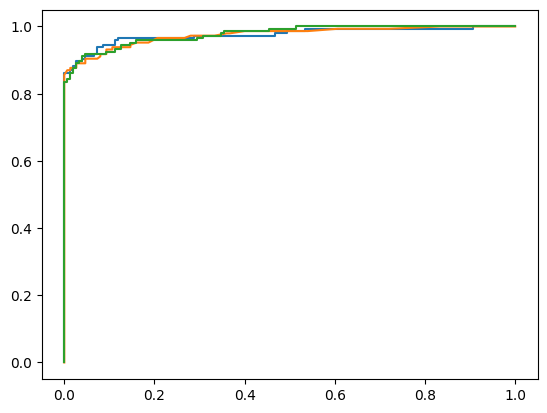

In [17]:
# Train and Evaluate Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_probs):.3f})")


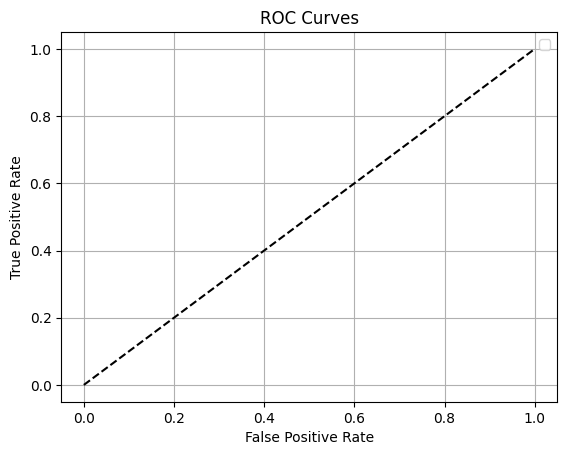

In [18]:
# Final ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()
